# 불친절한 튜토리얼 - Grad-CAM을 이용하는 법
친구가 파이썬, 딥러닝도 모르면서 Grad CAM은 써보고 싶다고 한다. 인중을 때려주고 싶지만, 소중한 뉴비가 이 분야를 이탈하지 않도록 도와주기 위해 이 코드를 작성한다.  

먼저 나중에 사용할 값들을 변수에 저장해놓자. 다 피가 되고 살이 된다.

In [1]:
input_shape = (28, 28, 1)
num_classes = 10

필요한 라이브러리들을 불러오자. 오류나면 설치하라.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

import tensorflow as tf
from tensorflow import keras

## MNIST 데이터셋 불러오기
- 케라스 내장 함수를 사용하여 MNIST 데이터를 불러온다. 실전에서는 당신의 데이터를 불러오면 된다.

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

- 데이터가 몇 개나 있나 확인해보자
    - 훈련 데이터는 60,000개, 테스트 데이터는 10,000개가 있으며 각 데이터는 $28 \times 28$ 행렬에 0부터 255 사이의 픽셀값이 적혀 있는 사진이다. 클래스 값으로는 0부터 9까지 가질 수 있다.
- `np.ndarray`의 `shape` attribute는 변수의 크기를 나타낸다. 
    - attribute란? 파이썬에는 **객체**라는 것이 존재한다. 객체 안에는 데이터도 넣을 수 있고, 함수도 넣을 수 있고, 이것 저것 다 넣을 수 있다. 넘파이 배열 (`np.ndarray`)은 객체다. attribute는 객체 안에 저장되어 있는 데이터 중 하나다.

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## 데이터 전처리
- CNN은 4차원 텐서 (데이터 개수, 높이, 너비, 채널)를 입력 받는다. 현재 `X_train`은 채널을 위한 축이 없기 때문에 이를 추가해줘야 한다.
- 딥러닝 프레임워크는 32비트 `float` 자료형을 입력 받는다.
- 딥러닝 프레임워크는 보통 데이터를 -1과 1사이 값으로 만들어준다.
- 클래스는 원핫인코딩이라는 것을 해줘야 한다.

In [5]:
X_train = X_train[..., np.newaxis]
X_train = X_train.astype(np.float32)
X_train = X_train / 255.0

X_test = X_test[..., np.newaxis]
X_test = X_test.astype(np.float32)
X_test = X_test / 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## 간단한 CNN 모델 만들기
- CNN 모델을 만든다. CNN 먼저 공부하고 오기를 바란다.

In [6]:
def get_basic_cnn(input_shape=(28, 28, 1), num_classes=10):
    cnn = keras.models.Sequential([
        keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
        keras.layers.MaxPool2D(),
        keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        keras.layers.MaxPool2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(num_classes),
        keras.layers.Softmax(),
    ])
    
    return cnn

- 만든 모델은 대충 아래 표처럼 구성되어 있다.

In [7]:
model = get_basic_cnn()
model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)        

2022-02-15 19:34:24.158477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-15 19:34:24.158629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 모델의 손실 함수, 최적화 알고리즘, 평가지표 설정

### 손실 함수란?
- 딥러닝 모델은 복잡해보이지만 그냥 하나의 함수라고 이해하면 된다. $f(x)=ax^2+bx+c$와 같은 2차 함수를 예로 들어보자. 입력값 $x$ 하나가 들어가면 출력값 $f(x)$가 나온다. $f(x)$는 $ax^2+bx+c$의 연산을 한다. 이 연산의 결과는 $a, b, c$ 값에 따라 달라진다. 딥러닝은 매우 복잡하게 생긴 함수로 이해하자.
- 위의 예시처럼 딥러닝 모델에는 $a, b, c$ 같은 학습 가능한 파라미터가 있다. 학습한다는 것은 $a, b, c$ 값을 점점 좋은 값으로 설정해준다는 것이다. 우리가 사용할 수 있는 $a, b, c$는 무수히 많을텐데, 좋은 $a, b, c$란 무엇일까?
- 좋은 $a, b, c$란 **손실 함수**를 최소로 만들어주는 $a, b, c$이다. 데이터를 $x$, 대응하는 정답을 $y$라고 해보자. 우리의 모델의 예측값은 $f(x)$라고 말했다. 그럼 $(y-f(x))$는 무엇이 되는가? 바로 오차가 된다. 우리의 바람은 $f(x)$가 $y$와 최대한 비슷해지는 것이다. 우리는 무수히 많은 $a, b, c$ 선택지 중에서 오차를 가장 작게 만들어주는 $a, b, c$를 찾을 것이다.
- 설명은 하나의 데이터에서 발생한 오차만을 고려했지만, 손실 함수는 보통 모든 데이터의 평균 오차를 최소화하게 된다. 오차는 양수일 수도 있고 음수일 수도 있기 때문에 모든 데이터의 오차를 더하면 양수와 음수가 서로 상쇄될 수 있다. 이를 방지하기 위해 오차 제곱의 평균을 최소화해준다. $\frac{1}{N} \sum_{i=1}^N (y_i - f(x_i))^2$
- 분류 문제에서는 위 손실 함수보다 **Cross Entropy**라는 손실 함수를 사용한다. 이건 당신이 공부하길 바란다. 하지만 철학을 동일하다. 모델의 예측 값 $f(x)$와 실제 클래스 $y$의 차이를 다 평균낸 것이다.

### 최적화 알고리즘이란?
- 우리의 목표를 정리하자면 우리의 모델 $f(x)$에 들어있는 학습 가능한 파라미터를 손실 함수를 최소로 만들어주는 녀석들로 설정하고 싶다.
- 학창 시절 함수의 최소값을 구하기 위해 함수를 미분하여 0되는 지점을 모두 조사했었다. 하지만 손실 함수는 굉장히 복잡해서 미분하여 0되는 지점을 계산할 수 없다.
- 그래서 이용하는 것이 최적화 알고리즘이다. 다 됐고, 손실함수를 낮추는 방향으로 학습 가능한 파라미터 $a, b, c$를 조금씩 조정하는 알고리즘이다. 그냥 adam 쓰셈

### 평가지표란?
- 손실 함수는 오차들의 평균이라고 했다. 그 값을 사람이 보기엔 의미를 해석하기 어렵다. 평가 지표는 사람이 이해하기 쉬운 다른 좋은 지표이다.

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='acc')

## 모델 학습
- 데이터를 직접 넣어서 $f(x)$를 구하고, 오차를 구하며, 모델 파라미터를 조정하는 과정이다.

In [9]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10


2022-02-15 19:34:24.274108: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-15 19:34:24.436238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


745/750 [============================>.] - ETA: 0s - loss: 0.2167 - acc: 0.9337

2022-02-15 19:34:31.644133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 8s 11ms/step - loss: 0.2157 - acc: 0.9341 - val_loss: 0.0729 - val_acc: 0.9775
Epoch 2/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0647 - acc: 0.9803 - val_loss: 0.0546 - val_acc: 0.9840
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0470 - acc: 0.9857 - val_loss: 0.0487 - val_acc: 0.9854
Epoch 4/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0360 - acc: 0.9887 - val_loss: 0.0403 - val_acc: 0.9877
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0302 - acc: 0.9901 - val_loss: 0.0389 - val_acc: 0.9883
Epoch 6/10
750/750 [==============================] - 8s 10ms/step - loss: 0.0238 - acc: 0.9924 - val_loss: 0.0471 - val_acc: 0.9858
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.0206 - acc: 0.9936 - val_loss: 0.0410 - val_acc: 0.9872
Epoch 8/10
750/750 [==============================] - 8s 10ms/step - loss: 0.017

## Grad-CAM
여기서부터 **Grad CAM** 내용이다. **Grad CAM**은 CNN 모델의 가장 마지막 feature maps에 대해서 모델의 출력값을 미분하는 과정을 포함한다. 


### Feature maps이란
화가 난다. feature maps을 설명해야 한다. 그것도 아주 쉽게.


딥러닝은 흔히 여러층으로 구성되어 있다고 한다. 각 층에서 일어나는 것은 **데이터 변환**이다. 예를 들어, 우리의 데이터가 4차원 벡터 $(179, 70, 29, -7.5)^\top$라고 하자. 4차원 벡터가 딥러닝에 들어가서 첫 번째 은닉층 (hidden layer)를 지나면 더 좋은 벡터가 된다. 예를 들어, 4차원 벡터가 10차원 벡터 $(-1.44,\; 0.488, \;\cdots, \;0.29)^\top$. 이 10차원 벡터를 만드는 과정에 위에서 말한 학습가능한 파라미터가 있는 것이다. 좋은 파라미터는 좋은 10차원 벡터를 만들어낸다. 10차원 벡터는 층을 지나면 다른 벡터가 된다. 이렇게 더 좋은 벡터로 만들어주는 과정을 반복한다. 그리고 마지막 벡터의 원소들로 연산을 해줘서 마지막 예측 값을 내뱉게 된다. 이 모든 과장에 학습 가능한 파라미터가 있다. 손실 함수를 줄여주는 방향으로 파라미터가 점점 조정되면, 각 층에서는 점점 문제를 풀기 좋은 벡터를 만들어낼 수 있게 된다.

CNN은 위의 설명에서 벡터를 이미지로 바꿔주면 된다. CNN은 이미지를 입력 받는다. 예를 들어, $28 \times 28 \times 3$ 크기의 이미지를 입력 받는다. 합성곱층 (convolutional layer)를 하나 지나면 더 좋은 이미지로 바뀌게 된다. 예를 들어, $26 \times 26 \times 32$ 크기의 이미지가 된다. 사실, 이 친구에게 이미지라는 단어는 더 이상 사용할 수 없을 것이다. 대신 우리는 이 친구를 feature map이라고 부른다. 즉, feature map은 합성곱층을 지나면서 만들어진 더 좋은 이미지라고 이해하면 쉽다.


**Grad CAM**에서 모델의 마지막 feature maps을 사용한다는 것은 그냥 마지막 합성곱층을 지난 좋은 이미지로 이해하면 된다.

---

### 왜 미분하는데
화가 난다. 왜 미분을 해야하는지 설명을 해야 한다. 그것도 아주 쉽게.

미분이 무엇인가? $x$에서 함수 $f(x)$의 미분 값은 $x$가 아주 조금 변했을 때 $f(x)$가 얼마나 변하느냐를 나타내는 것이다.

그럼 마지막 feature maps으로 우리의 모델을 미분한다는 것은 무슨 의미인가? feature maps이 아주 조금 변했을 때, 우리의 모델이 얼마나 변하느냐를 나타낸다. 모델이 많이 변하고 조금 변하는 것이 무엇을 의미할까? 개와 고양이를 분류하는 예시를 생각해보자. 지금 우리의 모델이 충분히 훌륭해서 개는 개라고, 고양이는 고양이라고 잘 분류한다고 가정하자. 이때, 개 사진에서 얼굴을 고양이로 바꿔보자. 모델의 예측값은 개에서 고양이로 급변할 것이다. 반면, 사진의 배경을 맑은 날에서 흐린 날로 바꾼다고 해서 모델의 예측 값이 개에서 고양이로 바뀌진 않을 것이다. 이 예시가 무엇을 의미하는가? 사진에서 중요한 부분일 수록 조금만 변형을 가해도 모델의 예측값에 큰 변화를 준다. 마지막 feature maps에서 중요한 영역은 조금만 변해도 모델의 예측값이 크게 변하기 때문에 큰 미분값을 가질 것이고, 반대로 그다지 중요하지 않은 영역은 미분값이 작을 것이다.

---

글 쓰다가 귀찮아져서 코드를 그대로 베껴왔다.

In [14]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

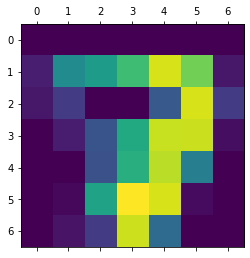

In [16]:
heatmap = make_gradcam_heatmap(X_test[0:1], model, 'max_pooling2d_1')
plt.matshow(heatmap)
plt.show()

In [39]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


img = X_test[1200]
heatmap =  make_gradcam_heatmap(img[np.newaxis], model, 'max_pooling2d_1')
save_and_display_gradcam(img, heatmap)